In [1]:
import sys
# TODO: clean this up
sys.path.insert(0, "/Users/danieldubovski/projects/deep_query_optimization/")
# sys.path

In [2]:
from dqo.datasets import QueriesDataset, ExtendedQueriesDataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [73]:
ds = ExtendedQueriesDataset("imdb:extended")

In [74]:
db = ds.schema()

In [75]:
df = ds.load()

2021-08-15 10:33:57,854 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/extended/runtimes/dqo.cayusbvr71xr.us-east-1.rds.amazonaws.com_imdb_1626365832_extended.csv [1/2]
2021-08-15 10:34:01,258 | dqo.datasets | INFO | Loaded 27512 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/extended/runtimes/dqo.cayusbvr71xr.us-east-1.rds.amazonaws.com_imdb_1626365832_extended.csv [1/2]
2021-08-15 10:34:01,259 | dqo.datasets | INFO | Reading data from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/extended/runtimes/dqo.cayusbvr71xr.us-east-1.rds.amazonaws.com_imdb_1626442217_extended.csv [2/2]
2021-08-15 10:34:03,855 | dqo.datasets | INFO | Loaded 27512 rows from /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/imdb/execution/extended/runtimes/dqo.cayusbvr71xr.us-east-1.rds.amazonaws.com_imdb_1626442217_extended.csv [2/2]


In [76]:
df = ds.df.query('runtime > 0.01')

In [77]:
df.runtime.describe()

count    52257.000000
mean         0.624346
std          1.461051
min          0.010032
25%          0.244244
50%          0.523185
75%          0.820384
max         74.130100
Name: runtime, dtype: float64

In [85]:
len(df['query'].unique()), len(df)

(26196, 26196)

In [84]:
df = df.drop_duplicates('query')

---

In [52]:
df = ds.groom()

100%|██████████| 25057/25057 [05:55<00:00, 70.39it/s]  


----

In [86]:
len(df.query('runtime > 0.01 and runtime < 500')), len(df)

(26196, 26196)

(array([2.5619e+04, 2.0600e+02, 0.0000e+00, 3.5000e+02, 0.0000e+00,
        5.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 1.1000e+01]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

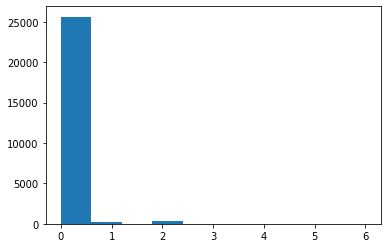

In [87]:
df['bucket'] = df.runtime.apply(np.log2).apply(np.round).apply(lambda x: max(0, x)).apply(lambda x: min(x,8)).astype(int)
plt.hist(df['bucket'])

In [88]:
df.groupby('bucket').count()

,query,runtime,plan
bucket,,,
0,25619,25619,25619
1,206,206,206
2,350,350,350
3,5,5,5
4,1,1,1
5,4,4,4
6,11,11,11


In [30]:
mean_count = int(df.groupby('bucket').count().mean().head(1)[0])
mean_count

2520

In [31]:
# cap to limit variance
df = df.groupby('bucket').head(mean_count * 4)

In [32]:
ds.df = df

In [16]:
df = ds.groom()

100%|██████████| 18717/18717 [04:01<00:00, 77.58it/s]


In [18]:
len(ds.df), len(df)

(18717, 18281)

In [73]:
ds.input_path

'/Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcd/execution/extended/runtimes'

In [74]:
df.query('nodes > 125').count()

query      6
runtime    6
plan       6
bucket     6
nodes      6
parts      6
dtype: int64

In [75]:
df = df.query('nodes < 125')

In [76]:
ds.df = df

In [77]:
df.columns

Index(['query', 'runtime', 'plan', 'bucket', 'nodes', 'parts'], dtype='object')

In [78]:
ds.save(split=True)

In [33]:
df.groupby('nodes').count()

,query,runtime,plan,bucket,parts
nodes,,,,,
2.0,34,34,34,34,34
3.0,49,49,49,49,49
4.0,277,277,277,277,277
5.0,100,100,100,100,100
6.0,625,625,625,625,625
...,...,...,...,...,...
120.0,94,94,94,94,94
121.0,94,94,94,94,94
122.0,92,92,92,92,92


(array([3242., 3793., 3765., 3541., 2574., 1811., 1296., 1185., 1166.,
        1262.]),
 array([  2. ,  14.2,  26.4,  38.6,  50.8,  63. ,  75.2,  87.4,  99.6,
        111.8, 124. ]),
 <BarContainer object of 10 artists>)

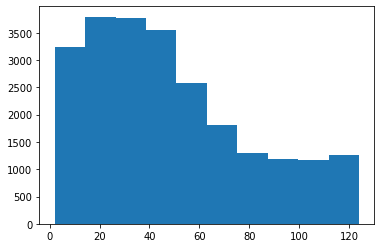

In [22]:
plt.hist(ds.df['nodes'])

___
# augment
---

In [210]:
bkts = sorted(list(ds.df[ds.df['bucket'] > 0].groupby('bucket').count().runtime))

In [211]:
min_bucket = bkts[1]
min_bucket

41

In [69]:
sample = df[df['bucket'] > 0].groupby('bucket').head(min_bucket)

(array([56., 80., 24., 77., 52., 74., 74., 37., 58., 32.]),
 array([0.50456446, 1.25410802, 2.00365157, 2.75319512, 3.50273868,
        4.25228223, 5.00182579, 5.75136934, 6.50091289, 7.25045645,
        8.        ]),
 <BarContainer object of 10 artists>)

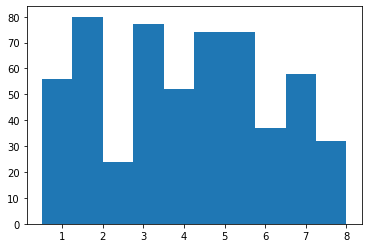

In [70]:
buckets = sample.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x))
plt.hist(buckets)

In [71]:
import os

In [72]:
batch_size = 1000
_df = sample
for i in range(0,len(_df), batch_size):
    aug_df = ds.augment(_df[i:i+batch_size])
    f_name = os.path.join(ds.input_path, f'aug_{batch_size}_{i}:{i + len(aug_df)}')
    print(i, len(aug_df), f_name)
    aug_df.to_csv(f_name, header=False, index=False, columns=['query', 'runtime'])

100%|██████████| 564/564 [00:46<00:00, 12.01it/s]


0 8178 /Users/danieldubovski/projects/deep_query_optimization/dqo/datasets/tpcd/execution/exec_time_clean/runtimes/aug_1000_0:8178


In [73]:
len(aug_df)

8178

In [74]:
ds.df.to_csv(os.path.join(ds.input_path, 'clean.csv'), header=False, index=False, columns=['query', 'runtime'])

(array([ 868., 1246.,  368.,  834.,  624., 1151., 1043.,  541.,  986.,
         517.]),
 array([0.50456446, 1.25410802, 2.00365157, 2.75319512, 3.50273868,
        4.25228223, 5.00182579, 5.75136934, 6.50091289, 7.25045645,
        8.        ]),
 <BarContainer object of 10 artists>)

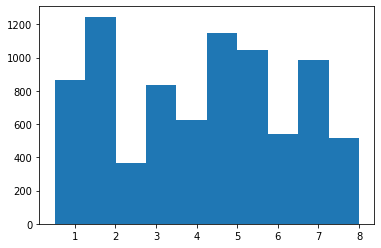

In [75]:
buckets = aug_df.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x))
plt.hist(buckets)


In [76]:
ds.save()

In [77]:
df['partition'] = df.runtime.apply(np.log2).apply(lambda x: min(x, 8)).apply(lambda x: max(0, x))
slow_df = df[df['partition'] > 4]
len(slow_df)

1024

In [78]:
import os
os.getcwd()

'/Users/danieldubovski/projects/deep_query_optimization/dqo/datasets'

In [79]:
with open('/Users/danieldubovski/projects/deep_query_optimization/dqo/localhost_imdb.qcp', 'w+') as dcp_file:
    for idx, row in slow_df.iterrows():
        dcp_file.write(f"{row['query']}\n")
    

In [80]:
from dqo.relational import SQLParser
from tqdm import tqdm

In [81]:
queries = []

for idx, row in tqdm(ds.df.iterrows(), total=ds.df.shape[0]):
    queries.append(SQLParser.to_query(row['query']))

100%|██████████| 5084/5084 [00:17<00:00, 291.44it/s]


In [82]:
db

Database(tables=[Table(dss_part, [Column(p_partkey, number), Column(p_name, string), Column(p_mfgr, string), Column(p_brand, string), Column(p_type, string), Column(p_size, number), Column(p_container, string), Column(p_retailprice, float), Column(p_comment, string)]), Table(dss_region, [Column(r_regionkey, number), Column(r_name, string), Column(r_comment, string)]), Table(dss_nation, [Column(n_nationkey, number), Column(n_name, string), Column(n_regionkey, number), Column(n_comment, string)]), Table(dss_customer, [Column(c_custkey, number), Column(c_name, string), Column(c_address, string), Column(c_nationkey, number), Column(c_phone, string), Column(c_acctbal, float), Column(c_mktsegment, string), Column(c_comment, string)]), Table(dss_order, [Column(o_orderkey, float), Column(o_custkey, number), Column(o_orderstatus, string), Column(o_totalprice, float), Column(o_orderdate, time), Column(o_orderpriority, string), Column(o_clerk, string), Column(o_shippriority, number), Column(o_com

In [83]:
from collections import defaultdict, Counter
tables = defaultdict(int)
for query in queries:
    c = Counter([r.name for r in query._relations])
    for k, v in c.items():
        tables[k] += v
    
tables_df = pd.DataFrame(tables.items(), columns=['table', 'count'])
tables_df
    

,table,count
0,dss_region,3296
1,dss_partsupp,3767
2,dss_lineitem,4984
3,dss_part,4395
4,dss_order,4270
5,dss_customer,4072
6,dss_nation,3165
7,dss_supplier,3903


# SAVE

In [71]:
ds.df = df
ds.save(split=True)

In [72]:
len(df)

35392